In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
class Grid:
    def __init__(self, N, xmin=0.0, xmax=1.0):
        assert(N % 2 == 0)
        self.N = N
        self.xmin = xmin
        self.xmax = xmax
        self.h = (self.xmax-self.xmin)/self.N
        self.h2 = self.h**2
        self.x = np.linspace(0.0, 1.0, self.N, endpoint=False) + 0.5/self.N
    
class MGMatrices(Grid):
    def __init__(self, N, xmin=0.0, xmax=1.0):
        Grid.__init__(self, N, xmin=xmin, xmax=xmax)
        
        self.AA = self.set_AA(self.N)
        self.RR = self.set_RR(self.N)
        self.II = self.set_II(self.N)
        
    def set_AA(self, N):
        AA = np.zeros((N, N))
        stencil = np.array([1,-2,1]) / self.h2
        AA[0,:2] = stencil[1:]
        for i in range(1,N-1):
            AA[i,i-1:i+2] = stencil[:]
        AA[-1,-2:] = stencil[:-1]
        return AA
    
    def smoothing_full(self, u, rhs):
        """
        smoothing: this is a single step Jacobi iteration
        """
        assert(u.shape[0] % 2 == 0)
        v = u.copy()
        v[0]    = 1.0/3.0* (v[1] - self.h2 * rhs[0] )
        v[1:-1] = 0.5*(v[2:] + v[:-2] - self.h2 * rhs[1:-1] )
        v[-1]   = 1.0/3.0*(v[-2] - self.h2 * rhs[-1] )
        return v
    
    def set_RR(self, N):
        assert(N % 2 == 0)

        RR = np.zeros((N//2, N))
        for i in range(N//2):
            RR[i,2*i+0] = 0.5
            RR[i,2*i+1] = 0.5
        return RR

    def set_II(self, N):
        """
        Matrix for interpolation. Zero BC only
        """
        assert(N % 2 == 0)

        II = np.zeros((N, N//2))
        II[0,0] = 0.5
        for i in range(N//2-1):
            II[1+2*i, i+0] = 0.75
            II[1+2*i, i+1] = 0.25
            II[2+2*i, i+0] = 0.25
            II[2+2*i, i+1] = 0.75
        II[-1,-1] = 0.5
        return II

    def smoothing_jacobi(self, u, rhs, omega=2.0/3.0):
        return (1.0-omega)*u + omega*self.smoothing_full(u, rhs)

In [4]:
class MultiGrid(MGMatrices):
    def __init__(self, Nmax, xmin=0.0, xmax=1.0, maxlevel=2, nu=2):
        """
        Args:
            Nmax : number of cells at the finest level
        """
        self.Nmax = Nmax
        self.xmin = xmin
        self.xmax = xmax
        self.nu = nu
        
        self.maxlevel = int(np.log(Nmax)/np.log(2))
        if maxlevel < self.maxlevel:
            self.maxlevel = maxlevel
            
        self.Nlist = [self.Nmax//(2**i) for i in range(0, self.maxlevel)]
        
        print(self.maxlevel, self.Nlist)
        
        self.GridList = []
        for i in range(self.maxlevel):
            self.GridList.append( MGMatrices(self.Nlist[i], self.xmin, self.xmax) )
        
        
    def smoothing(self, u, rhs, level, nu=None):
        """
        Args:
            u, rhs :
            nu : number of times to iterate
        """
        if nu is None:
            nu = self.nu        
        
        uout = u.copy()
        for j in range(nu):
            #print("\t smoothing for the {}-th times".format(j))
            uout = self.GridList[level].smoothing_jacobi(uout, rhs)
        return uout
       
        
    def computeCorrection(self, u, f, level):
        """
        computeCorrection:
        - if level == maxlevel:
            f = R e_l-1
            
        - elif level < maxlevel:
        
        """
        if level==self.maxlevel-1:
            #print("level =  {} (max)".format(level))
            #print("\t solve A_L e_L = r_L")
            e_curr = np.linalg.solve(self.GridList[level].AA, f)
        else:
            #print("level = ", level)
            u = self.smoothing(u, f, level)
            #print("\t computing residual: r = f - A_l u_l")
            r = f - np.dot(self.GridList[level].AA, u)
            #print("\t restriction from l to l+1 level")
            #r_c = R_l r
            rc = np.dot(self.GridList[level].RR, r)
            u_next = np.zeros_like(rc)
            e_next = self.computeCorrection( u_next, rc, level+1)
            #print("\t interpolation from l+1 to l-th level")
            e_curr = np.dot(self.GridList[level].II, e_next)
            #print("level = ", level)
            e_curr = self.smoothing(e_curr, f, level)
            
        return e_curr

In [5]:
func = lambda x: np.sin(x) # this is RHS
MG = MultiGrid(Nmax=2**4, maxlevel=10)
rhs_fine = func(MG.GridList[0].x)
corr = MG.computeCorrection(np.zeros(MG.Nmax),rhs_fine,level=0)

4 [16, 8, 4, 2]


In [6]:
for i in range(MG.maxlevel):
    print(MG.GridList[i].x)

[0.03125 0.09375 0.15625 0.21875 0.28125 0.34375 0.40625 0.46875 0.53125
 0.59375 0.65625 0.71875 0.78125 0.84375 0.90625 0.96875]
[0.0625 0.1875 0.3125 0.4375 0.5625 0.6875 0.8125 0.9375]
[0.125 0.375 0.625 0.875]
[0.25 0.75]


C:\Users\quant\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


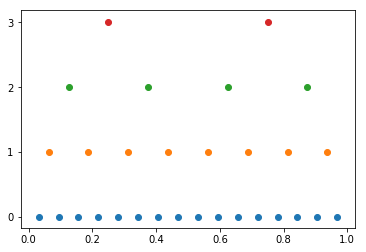

In [7]:
fig, ax = plt.subplots()
for i in range(MG.maxlevel):
    x = MG.GridList[i].x
    y = np.ones_like(x)*i
    ax.scatter(x,y)
ax.set_yticks(range(MG.maxlevel))

4 [64, 32, 16, 8]
l2 = 0.0005393463612586322


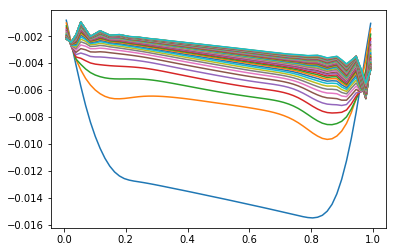

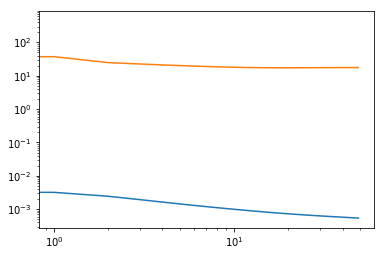

In [13]:
sol_f = lambda x: -np.sin(x) + np.sin(1.0) * x

MG = MultiGrid(Nmax=64, maxlevel=4, nu=1)
rhs_fine = func(MG.GridList[0].x)


u_init = MG.GridList[0].x * (1.0-MG.GridList[0].x) * 0.1
u = u_init.copy()
u_sol = sol_f(MG.GridList[0].x)

fig, ax = plt.subplots()
#ax.plot(MG.GridList[0].x, u_sol , 'k--')
#ax.plot(MG.GridList[0].x, rhs_fine , 'r--')
#ax.plot(MG.GridList[0].x, u_init - u_sol)

l2list = []
reslist = []
for itr in range(50):
    corr = MG.computeCorrection(u,rhs_fine,level=0)
    u += corr
    res = rhs_fine - np.dot(MG.GridList[0].AA, corr)
    ax.plot(MG.GridList[0].x, u-u_sol)
    l2 = np.sum( (u - u_sol)**2)
    l2list.append(l2)
    reslist.append(np.sum(res**2))
    
    
print("l2 = {}".format(l2))

fig, ax = plt.subplots()
ax.plot(l2list)
ax.plot(reslist)
ax.set_yscale("log")
ax.set_xscale("log")

In [14]:
u_init

array([0.00077515, 0.00228882, 0.00375366, 0.00516968, 0.00653687,
       0.00785522, 0.00912476, 0.01034546, 0.01151733, 0.01264038,
       0.0137146 , 0.01473999, 0.01571655, 0.01664429, 0.01752319,
       0.01835327, 0.01913452, 0.01986694, 0.02055054, 0.0211853 ,
       0.02177124, 0.02230835, 0.02279663, 0.02323608, 0.02362671,
       0.02396851, 0.02426147, 0.02450562, 0.02470093, 0.02484741,
       0.02494507, 0.0249939 , 0.0249939 , 0.02494507, 0.02484741,
       0.02470093, 0.02450562, 0.02426147, 0.02396851, 0.02362671,
       0.02323608, 0.02279663, 0.02230835, 0.02177124, 0.0211853 ,
       0.02055054, 0.01986694, 0.01913452, 0.01835327, 0.01752319,
       0.01664429, 0.01571655, 0.01473999, 0.0137146 , 0.01264038,
       0.01151733, 0.01034546, 0.00912476, 0.00785522, 0.00653687,
       0.00516968, 0.00375366, 0.00228882, 0.00077515])

4100 117.88414025072484
4200 117.96658447534351
4300 118.03969761634582
4400 118.10453268737703
4500 118.16202453194308
4600 118.21300294182491
4700 118.25820435009504
4800 118.29828224685147
4900 118.33381645190002


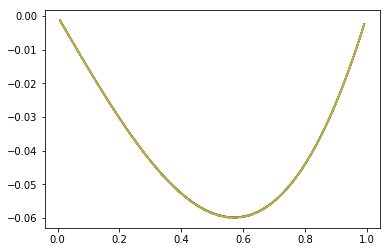

In [31]:
u = -u_init.copy()
fig, ax = plt.subplots()
ax.plot(MG.GridList[0].x, u_sol, 'k--')
for itr in range(5000):
    u = MG.GridList[0].smoothing_full(u, rhs_fine)
    if itr % 100 == 0 and itr > 4000:
        ax.plot(MG.GridList[0].x, u)
        res = rhs_fine - np.dot(MG.GridList[0].AA, u)
        print(itr, np.sum(res**2))